In [21]:
import polars as pl
import pysentiment2 as ps
import math
import os
import re
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

In [22]:
lm_dict = pl.read_csv(r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\Loughran-McDonald_MasterDictionary_1993-2021.csv')
hv_dict = pl.read_excel(r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\converter_api\Harvard_inquirerbasic.xls')
hv_dict.sample(10)

Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,Submit,Active,Passive,Pleasur,Pain,Feel,Arousal,EMOT,Virtue,Vice,Ovrst,Undrst,Academ,Doctrin,Econ@,Exch,ECON,Exprsv,Legal,Milit,Polit@,POLIT,Relig,Role,COLL,Work,…,WltTran,WltOth,WltTot,WlbGain,WlbLoss,WlbPhys,WlbPsyc,WlbPt,WlbTot,EnlGain,EnlLoss,EnlEnds,EnlPt,EnlOth,EnlTot,SklAsth,SklPt,SklOth,SklTot,TrnGain,TrnLoss,TranLw,MeansLw,EndsLw,ArenaLw,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othtags,Defined
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,null,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,null,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""THUS""","""H4Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Ovrst""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""LY""","""| adverb: So, …"
"""FORTHCOMING""","""H4Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""TimeSpc""",null,"""Modif""","""|"""
"""YOUR""","""H4Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""DET GEN Scndp""","""| det: Possess…"
"""GRAND""","""H4Lvd""","""Positiv""",null,"""Pstv""",null,null,null,"""Strong""",null,null,null,null,null,null,null,null,null,null,"""Virtue""",null,"""Ovrst""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""PosAff""",null,null,null,null,null,"""Modif""","""|"""
"""MUNICIPAL""","""H4Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ECON""",null,null,null,"""Polit@""","""POLIT""",null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Modif""","""|"""
"""PASTOR""","""H4Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Relig""","""Role""",null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Noun""","""|"""
"""TIME#_11""","""H4""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""LY""","""| 0% idiom-ver…"
"""REFUGE""","""H4""","""Positiv""",null,null,null,null,null,null,null,null,null,null,null,"""Pleasur""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null

In [23]:
#ensure that harvard dictionary entries are compatable with input strings
words = hv_dict.select(pl.col('Entry'))

hv_words = words.to_series().str.to_lowercase()

hv_words = hv_words.map_elements(lambda word: re.sub(r'#\d+', '', word))

hv_dict = hv_dict.replace_column(0, hv_words)

hv_dict = hv_dict.unique(subset="Entry", keep="last")

In [182]:
df_dict = {}

path = r'C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd'

for company_name in os.listdir(path):
    
    file_path = os.path.join(path, company_name)

    match = re.search(r"\\([A-Z]+(?:\.[A-Z])?)_reports\.parquet", file_path)

    if match:
        ticker_symbol = match.group(1)
        print("Ticker Symbol:", ticker_symbol, '\n', file_path)
    else:
        print(f"Ticker symbol for {company_name} is not found")

    df_name = f"{ticker_symbol}"
    df = pl.read_parquet(file_path)

    df_dict[df_name] = df

Ticker Symbol: AAL 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd\AAL_reports.parquet
Ticker Symbol: AAPL 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd\AAPL_reports.parquet
Ticker Symbol: ABBV 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd\ABBV_reports.parquet
Ticker Symbol: ABNB 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd\ABNB_reports.parquet
Ticker Symbol: ABT 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd\ABT_reports.parquet
Ticker Symbol: ACGL 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd\ACGL_reports.parquet
Ticker Symbol: ACN 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd\ACN_reports.parquet
Ticker Symbol: ADBE 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred_upd\ADBE_reports.parquet
Ticker Symbol: ADI 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_f

In [40]:
total_num_of_rep = 0

for value in df_dict.values():
    total_num_of_rep += value.width
print(total_num_of_rep)

9830


In [39]:
total_num_of_words = 0

for value in df_dict.values():
    for col in value:
        total_num_of_words += col.count()

print(total_num_of_words)

21144808


In [41]:
#average doc length
average_word_count = total_num_of_words/total_num_of_rep
print(f'Average doc length in words: {round(average_word_count)}')
ln_average_word_count = math.log(average_word_count)

Average doc length in words: 2151


In [25]:
#ENSURE CASE CoMpAtAbIlItY
positive_words_lm = lm_dict.filter(lm_dict["Positive"] > 0).to_series().str.to_lowercase()
negative_words_lm = lm_dict.filter(lm_dict["Negative"] > 0).to_series().str.to_lowercase()

print(len(positive_words_lm) + len(negative_words_lm))

positive_words_hv = hv_dict.filter(hv_dict["Positiv"] == 'Positiv').to_series().str.to_lowercase()
negative_words_hv = hv_dict.filter(hv_dict["Negativ"] == 'Negativ').to_series().str.to_lowercase()

print(len(positive_words_hv) + len(negative_words_hv))

2692
3475


In [26]:
#LM dict also contain only unique words
len(positive_words_lm) == len(set(positive_words_lm.to_list()))

True

In [27]:
words_lm = positive_words_lm.to_frame().vstack(negative_words_lm.to_frame()).to_series().to_list()
words_hv = positive_words_hv.to_frame().vstack(negative_words_hv.to_frame()).to_series().to_list()

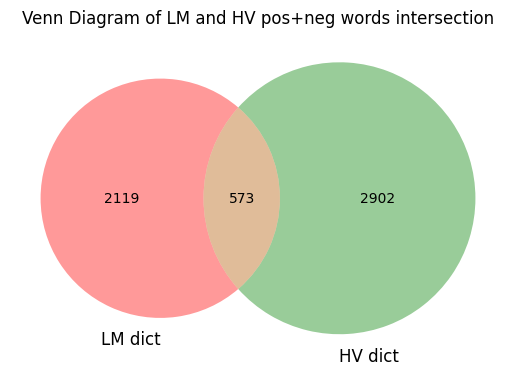

In [28]:
set_lm = set(words_lm)
set_hv = set(words_hv)

venn = venn2([set_lm, set_hv], set_labels=('LM dict', 'HV dict'))

plt.title('Venn Diagram of LM and HV pos+neg words intersection')
plt.show()

Clearly, there is a significant intersection between this to dictionaries. Now the goal is to construct three new dicts: Lm dict net of HV dict words, HV dict net of LM wors and the new dict out of words from intersetion.

In [29]:
#net LM dict

net_positive_lm = positive_words_lm.to_frame().join(positive_words_hv.to_frame(), left_on='Word', right_on='Entry', how='anti')
len_pos_lm1 = len(net_positive_lm)
net_positive_lm = net_positive_lm.join(negative_words_hv.to_frame(), left_on='Word', right_on='Entry', how='anti')
len_pos_lm2 = len(net_positive_lm)
print(f'Intersection between positive lm and negative hv is {len_pos_lm1 - len_pos_lm2} words')

print(f'Net_positive_lm is less then positive_words_lm on {len(positive_words_lm) - len(net_positive_lm)} words')

net_negative_lm = negative_words_lm.to_frame().join(negative_words_hv.to_frame(), left_on='Word', right_on='Entry', how='anti')
len_neg_lm1 = len(net_negative_lm)
net_negative_lm = net_negative_lm.join(positive_words_hv.to_frame(), left_on='Word', right_on='Entry', how='anti')
len_neg_lm2 = len(net_negative_lm)
print(f'Intersection between positive lm and negative hv is {len_neg_lm1 - len_neg_lm2} words')

print(f'Net_negative_lm is less then negative_words_lm on {len(negative_words_lm) - len(net_negative_lm)} words')

Intersection between positive lm and negative hv is 1 words
Net_positive_lm is less then positive_words_lm on 117 words
Intersection between positive lm and negative hv is 15 words
Net_negative_lm is less then negative_words_lm on 456 words


In [30]:
#validate separation
chec_set = set(positive_words_lm)
for word in net_positive_lm.to_series():
    if word not in chec_set:
        print('False')

chec_set = set(negative_words_lm)
for word in net_negative_lm.to_series():
    if word not in chec_set:
        print('False')

In [31]:
#net HV dict 

net_positive_hv = positive_words_hv.to_frame().join(positive_words_lm.to_frame(), left_on='Entry', right_on='Word', how='anti')
net_positive_hv = net_positive_hv.join(negative_words_lm.to_frame(), left_on='Entry', right_on='Word', how='anti')

print(f'Net_positive_hv is less then positive_words_hv on {len(positive_words_hv) - len(net_positive_hv)} words')

net_negative_hv = negative_words_hv.to_frame().join(negative_words_lm.to_frame(), left_on='Entry', right_on='Word', how='anti')
net_negative_hv = net_negative_hv.join(positive_words_lm.to_frame(), left_on='Entry', right_on='Word', how='anti')

print(f'Net_negative_hv is less then negative_words_hv on {len(negative_words_hv) - len(net_negative_hv)} words')

Net_positive_hv is less then positive_words_hv on 131 words
Net_negative_hv is less then negative_words_hv on 442 words


In [32]:
#validate separation
chec_set = set(positive_words_hv)
for word in net_positive_hv.to_series():
    if word not in chec_set:
        print('False')

chec_set = set(negative_words_hv)
for word in net_negative_hv.to_series():
    if word not in chec_set:
        print('False')

In [33]:
set_lm_pos = set(positive_words_lm)
set_lm_neg = set(negative_words_lm)
set_hv_pos = set(positive_words_hv)
set_hv_neg = set(negative_words_hv)

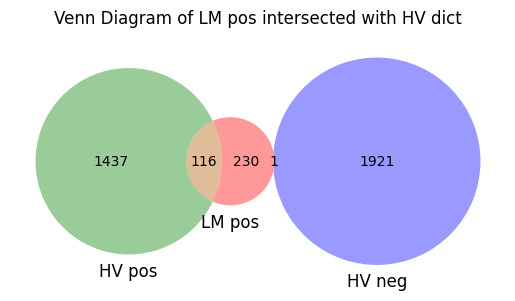

In [34]:
venn = venn3([set_lm_pos, set_hv_pos, set_hv_neg], set_labels=('LM pos', 'HV pos', 'HV neg'))

plt.title('Venn Diagram of LM pos intersected with HV dict')
plt.show()

As we can see on the graph, LM pos mostly intersected with negative part of HV dict. Acording to hypothesis, this this words from intersection are moving in the opposite direction with returns, despite, they are from positive part of dictionary. This intersection will be positive part of our intersected dictionary.

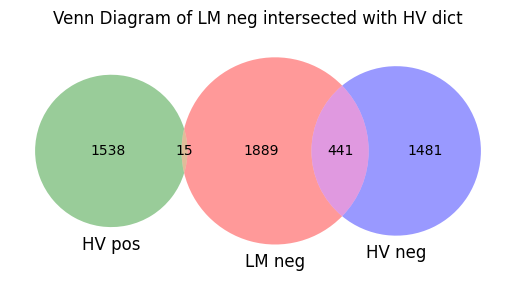

In [35]:
venn = venn3([set_lm_neg, set_hv_pos, set_hv_neg], set_labels=('LM neg', 'HV pos', 'HV neg'))

plt.title('Venn Diagram of LM neg intersected with HV dict')
plt.show()

Here we can see similar picture, intersections of cordinality 15 and 441 will be our negative part of our intersected dict. Intersected dict as a whole should behave ssimilar to LM dict. 

Lets create this dict.

In [36]:
# Intersecton dict
inter_pos1 = positive_words_lm.to_frame().join(positive_words_hv.to_frame(), left_on='Word', right_on='Entry', how='semi')
print(len(inter_pos1))
inter_pos2 = positive_words_lm.to_frame().join(negative_words_hv.to_frame(), left_on='Word', right_on='Entry', how='semi')
print(len(inter_pos2))

inter_pos = inter_pos1.vstack(inter_pos2)

inter_neg1 = negative_words_lm.to_frame().join(negative_words_hv.to_frame(), left_on='Word', right_on='Entry', how='semi')
print(len(inter_neg1))
inter_neg2 = negative_words_lm.to_frame().join(positive_words_hv.to_frame(), left_on='Word', right_on='Entry', how='semi')
print(len(inter_neg2))

inter_neg = inter_neg1.vstack(inter_neg2)

116
1
441
15


In [37]:
#example series 
example_series = df_dict['ALGN'][df_dict['ALGN'].columns[1]]
example_df = df_dict['ALGN']
example_df

2019-02-28_41967,2019-05-02_23700,2019-08-01_25159,2019-10-31_25727,2020-02-28_41700,2020-05-05_29591,2020-07-31_31169,2020-10-30_31283,2021-02-26_51814,2021-05-05_24843,2021-08-04_27369,2021-11-02_29192,2022-02-25_51116,2022-05-05_31211,2022-08-04_31365,2022-11-04_32365,2023-02-27_48299,2023-05-05_25156,2023-08-04_26049,2023-11-03_26861
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal""","""principal"""
"""delinquent""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company"""
"""best""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company"""
"""knowledge""","""company""","""company""","""company""","""shell""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company"""
"""definitive""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company""","""company"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
null,null,null,null,null,null,null,null,null,null,null,null,"""omitted""",null,null,null,null,null,null,null
null,null,null,null,null,null,null,null,null,null,null,null,"""behalf""",null,null,null,null,null,null,null
null,null,null,null,null,null,null,null,null,null,null,null,"""substitution""",null,null,null,null,null,null,null


This func counts positive and negative appearences in doc (series) for each (out of three) dictionaries. After that it calculates polarity score for this serires out of each dict.

In [189]:
def count_scores_in_doc(series):
        
        #grouped series that became a df, where each row is unique word and its count in document 
        num_of_w = series.value_counts().rename({"count": "count in doc"})

        #first col of this df (only words by itself)
        only_w = num_of_w[num_of_w.columns[0]]

        #count the words from net LM dictionary and so it's polarity score
        pos_net_lm = num_of_w.filter(only_w.is_in(net_positive_lm)).select(pl.col("count in doc")).sum().item()
        neg_net_lm = num_of_w.filter(only_w.is_in(net_negative_lm)).select(pl.col("count in doc")).sum().item()

        lm_net_polarity_score = (pos_net_lm - neg_net_lm) / (pos_net_lm + neg_net_lm)

        #count the words from net HV dictionary and so it's polarity score
        pos_net_hv = num_of_w.filter(only_w.is_in(net_positive_hv)).select(pl.col("count in doc")).sum().item()
        neg_net_hv = num_of_w.filter(only_w.is_in(net_negative_hv)).select(pl.col("count in doc")).sum().item()

        hv_net_polarity_score = (pos_net_hv - neg_net_hv) / (pos_net_hv + neg_net_hv)

        #count the words from intersection dictionary and so their polarity score
        pos_inter = num_of_w.filter(only_w.is_in(inter_pos)).select(pl.col("count in doc")).sum().item()
        neg_inter = num_of_w.filter(only_w.is_in(inter_neg)).select(pl.col("count in doc")).sum().item()

        inter_polarity_score = (pos_inter - neg_inter) / (pos_inter + neg_inter)

        
        return [lm_net_polarity_score, hv_net_polarity_score, inter_polarity_score]

count_scores_in_doc(example_series)


[-0.7294117647058823, 0.5714285714285714, -0.6514745308310992]

This func extracts the doc len from the title of the series.

In [206]:
len_pattern = r"_(\d+)$"
date_pattern = r"\d{4}-\d{2}-\d{2}"

def get_len_and_date(series):
    
    match_len = re.search(len_pattern, series.name)
    doc_len = match_len.group(1)

    match_date = re.search(date_pattern, series.name)
    date = match_date.group(0)

    return int(doc_len), date
    
get_len_and_date(example_series)


(23700, '2019-05-02')

In [209]:
counter = 0

for company_name, df in df_dict.items():

    score_dict = {}

    for col in df:
        
        score_lst = count_scores_in_doc(col)
        doc_len, date = get_len_and_date(col)

        score_lst.append(doc_len)
        
        score_dict[date] = score_lst
    
    df = pl.DataFrame(score_dict)
    counter += 1
    
    print(f'Iteration for {company_name} is done successfully; \n {len(df_dict) - counter} remaining')

    # Determine the output directory and file name
    output_dir = os.path.join('data', 'intersection_scores')
    os.makedirs(output_dir, exist_ok=True)

    file_name_new = f"{company_name}_inter_scores.parquet"
    full_path = os.path.join(output_dir, file_name_new)
    full_path = os.path.normpath(full_path)

    # Write the DataFrame to Parquet
    df.write_parquet(full_path)

    print(f"{full_path} created successfully")

Iteration for AAL is done successfully; 
 496 remaining
data\intersection_scores\AAL_inter_scores.parquet created successfully
Iteration for AAPL is done successfully; 
 495 remaining
data\intersection_scores\AAPL_inter_scores.parquet created successfully
Iteration for ABBV is done successfully; 
 494 remaining
data\intersection_scores\ABBV_inter_scores.parquet created successfully
Iteration for ABNB is done successfully; 
 493 remaining
data\intersection_scores\ABNB_inter_scores.parquet created successfully
Iteration for ABT is done successfully; 
 492 remaining
data\intersection_scores\ABT_inter_scores.parquet created successfully
Iteration for ACGL is done successfully; 
 491 remaining
data\intersection_scores\ACGL_inter_scores.parquet created successfully
Iteration for ACN is done successfully; 
 490 remaining
data\intersection_scores\ACN_inter_scores.parquet created successfully
Iteration for ADBE is done successfully; 
 489 remaining
data\intersection_scores\ADBE_inter_scores.par